# Intrinsic performance metrics for MOOC graph

In [1]:
import os
os.chdir('..')
print(os.getcwd())

import pickle
from tigger_package.orchestrator import Orchestrator
from tigger_package.metrics.distribution_metrics import NodeDistributionMetrics, EdgeDistributionMetrics
from tigger_package.tools import plot_adj_matrix
import networkx as nx 
import pandas as pd
import time

/Users/tonpoppe/workspace/tigger_adj_rep/tigger_adj
loaded
loaded


In [2]:
base_folder = "data/mooc/"
orchestrator = Orchestrator(base_folder)
nodes = orchestrator._load_nodes()
synth_nodes = pd.read_parquet('data/mooc/synth_graph/node_attributes_final.parquet')

edges = orchestrator._load_edges()
synth_edges = pd.read_parquet('data/mooc/synth_graph/adjacency_final.parquet')
print(f"orig has {edges.shape} format and synth edges {synth_edges.shape}")



orig has (178443, 7) format and synth edges (6732, 7)


# plot graphs

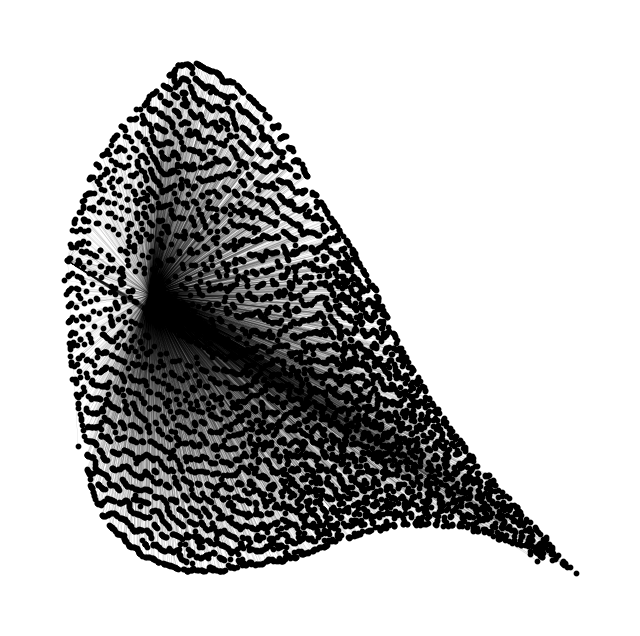

In [3]:
plot_adj_matrix(synth_edges)

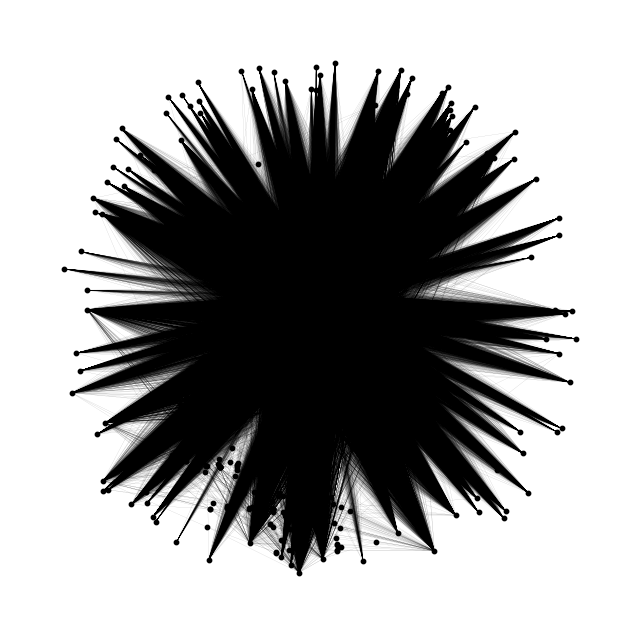

In [4]:
plot_adj_matrix(edges.rename(columns={'start': 'src', 'end': 'dst'}))

# node attributes

In [5]:
ndm = NodeDistributionMetrics(nodes, synth_nodes)
ndm.calculate_wasserstein_distance()

,value,type,metric
degree,0.168775,node_attributes,Wasserstein_distance
LABEL,0.175142,node_attributes,Wasserstein_distance
is_user,0.804003,node_attributes,Wasserstein_distance


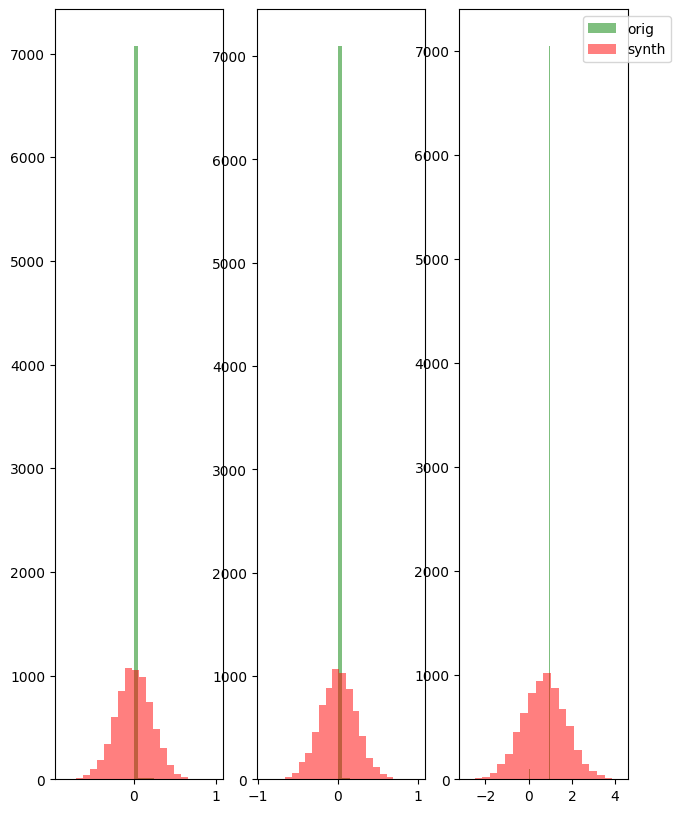

In [6]:
ndm.plot_hist()

# Edge atributes

In [7]:
edm = EdgeDistributionMetrics(edges, synth_edges)
edm.calculate_wasserstein_distance()


,value,type,metric
FEATURE0,0.330724,edge_attributes,Wasserstein_distance
FEATURE1,0.237120,edge_attributes,Wasserstein_distance
FEATURE2,0.010122,edge_attributes,Wasserstein_distance
FEATURE3,0.004266,edge_attributes,Wasserstein_distance
weight,0.185755,edge_attributes,Wasserstein_distance


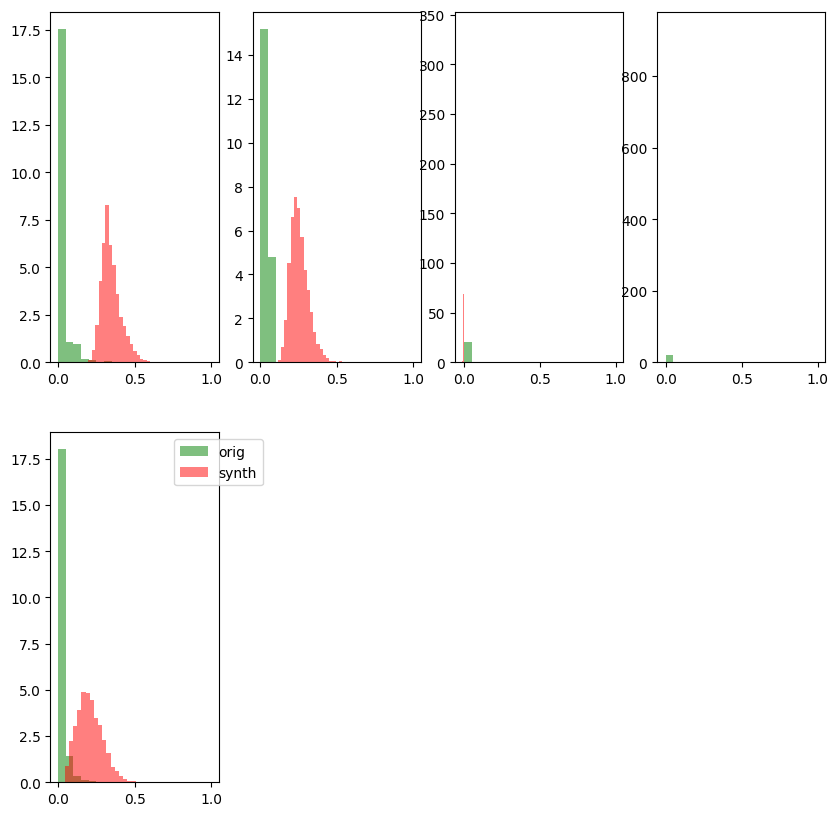

In [8]:
edm.plot_hist()


In [9]:
edm.get_degree_wasserstein_distance()


,value,type,metric
in_degree,0.989474,edge_degree,Wasserstein_distance
out_degree,131.926316,edge_degree,Wasserstein_distance


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Users/tonpoppe/workspace/tigger_adj_rep/tigger_adj/tigger_package/metrics/distribution_metrics.py:150: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


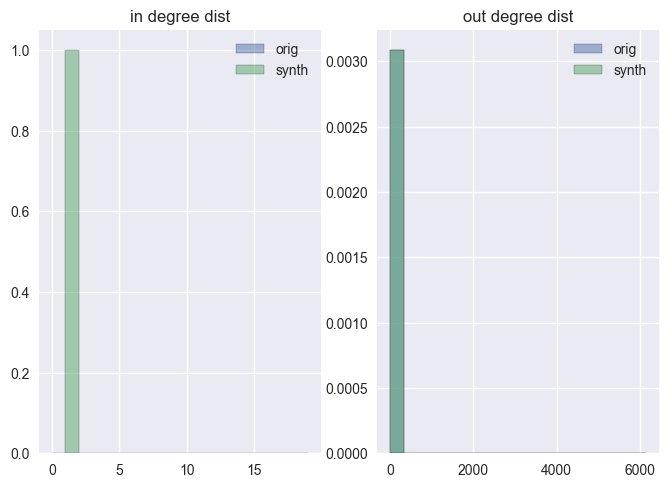

In [10]:
edm.plot_degree_dst()

# check clustering

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/178443 [00:00<?, ?it/s]

Number of components, 14


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Text(0.5, 1.0, 'distribution of cluster id in the data set')

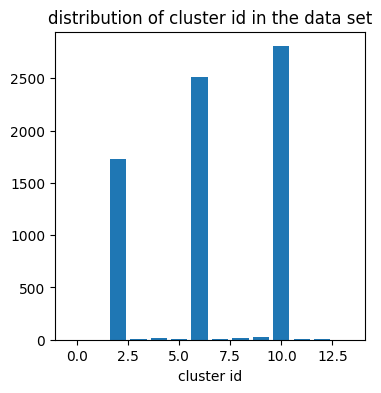

In [3]:
import matplotlib.pyplot as plt
import numpy as np
orchestrator = Orchestrator(base_folder)
orchestrator.init_lstm()
inductiveController = orchestrator.inductiveController
cl = inductiveController.cluster_labels
cl_id, height = np.unique(cl, return_counts=True)
plt.figure(figsize=(4,4))
plt.bar(cl_id, height)
plt.xlabel("cluster id")
plt.title("distribution of cluster id in the data set")


In [13]:
vocab = inductiveController.vocab
# (new_vocab_id : orig_id)
len(vocab)

7146

In [11]:
len(cl)  #7146  heeft ook pad en end
# nodes.shape (7144, 3)

7146

KeyError: 7144

,cluster_id
0,6
1,2
2,6
3,6
4,6
...,...
7138,9
7143,9
7139,9
7140,9


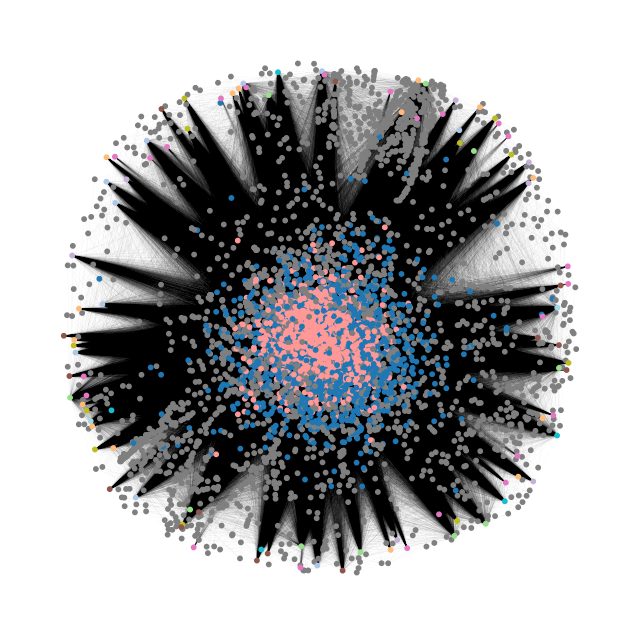

In [23]:
# Create dataframe with node_id as index and cluster_id
cl_orig_id = {k : cl[v] for k, v in vocab.items()}
cl_orig_id.pop('<PAD>')
cl_orig_id.pop('end_node')
cluster_df = pd.DataFrame.from_dict(cl_orig_id, orient='index', columns=['cluster_id']) 

G = nx.from_pandas_edgelist(edges, source='start', target='end', edge_attr=['weight'], create_using=nx.DiGraph)
for n in G.nodes():
    G.nodes[n]['cluster'] = cluster_df.loc[n]
       
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
nx.draw_networkx_edges(G, pos, width=0.1, arrows=False, alpha=0.1)
nx.draw_networkx_nodes(
    G, pos,
    nodelist=list(cluster_df.index),
    node_size=10,
    node_color=list(cluster_df['cluster_id']),
    cmap=plt.cm.tab20,
)

plt.axis("off")
plt.show() 